In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import yfinance as yf
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

In [ ]:
# Initialize Firebase
cred = credentials.Certificate('/content/drive/MyDrive/Predictions/financiaflutter-firebase-adminsdk-ajaw7-f515e50a59.json')
firebase_admin.initialize_app(cred)

In [ ]:
crypto_currency = 'BTC'
against_currency = 'USD'

start = dt.datetime(2016,1,1)
end = dt.datetime.now()

data = yf.download('BTC-USD', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


Prepare Data

In [ ]:
print(data.tail())

                    Open          High           Low         Close  \
Date                                                                 
2023-07-30  29357.093750  29443.169922  29059.501953  29275.308594   
2023-07-31  29278.314453  29489.873047  29131.578125  29230.111328   
2023-08-01  29230.873047  29675.732422  28657.023438  29675.732422   
2023-08-02  29704.146484  29987.998047  28946.509766  29151.958984   
2023-08-07  29040.876953  29149.074219  28980.794922  29016.990234   

               Adj Close       Volume  
Date                                   
2023-07-30  29275.308594   8678454527  
2023-07-31  29230.111328  11656781982  
2023-08-01  29675.732422  18272392391  
2023-08-02  29151.958984  19212655598  
2023-08-07  29016.990234   8327560192  


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data['Close'].values.reshape(-1,1)

array([[  434.33401489],
       [  433.43798828],
       [  430.01098633],
       ...,
       [29675.73242188],
       [29151.95898438],
       [29016.99023438]])

In [ ]:
scalar= MinMaxScaler(feature_range=(0,1))
scaled_data =scalar.fit_transform(data['Close'].values.reshape(-1,1))
scaled_data.shape

(2772, 1)

In [ ]:
prediction_days = 60
future_day = 10

x_train, y_train=[], []

In [ ]:
for x in range(prediction_days, len(scaled_data)-future_day):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x+future_day, 0])


In [ ]:
 x_train[70]

array([0.00085352, 0.00070374, 0.00074006, 0.00077537, 0.00078121,
       0.0007839 , 0.00083762, 0.00067285, 0.00068618, 0.00073545,
       0.00072878, 0.00079994, 0.00079923, 0.00077472, 0.00078637,
       0.0007978 , 0.00092904, 0.00089134, 0.00077653, 0.00075124,
       0.0007797 , 0.00079802, 0.00084137, 0.00084183, 0.00084986,
       0.00088835, 0.00087916, 0.00086922, 0.00083357, 0.00081961,
       0.00085165, 0.00086533, 0.00090561, 0.00088394, 0.0008921 ,
       0.00097291, 0.00098569, 0.00093848, 0.00095621, 0.00105916,
       0.00114665, 0.00126623, 0.00121135, 0.00127899, 0.00140209,
       0.00144481, 0.0015142 , 0.00119573, 0.00126007, 0.00135063,
       0.00124976, 0.00130269, 0.00119546, 0.00127931, 0.00122601,
       0.00124467, 0.00141769, 0.00140181, 0.00140199, 0.00143078])

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(2702, 60)

In [ ]:
y_train.shape

(2702,)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Create Neural Network

In [ ]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
85/85 [==============================] - 28s 216ms/step - loss: 0.0105
Epoch 2/25
85/85 [==============================] - 10s 117ms/step - loss: 0.0043
Epoch 3/25
85/85 [==============================] - 8s 94ms/step - loss: 0.0044
Epoch 4/25
85/85 [==============================] - 10s 117ms/step - loss: 0.0039
Epoch 5/25
85/85 [==============================] - 10s 116ms/step - loss: 0.0038
Epoch 6/25
85/85 [==============================] - 8s 93ms/step - loss: 0.0042
Epoch 7/25
85/85 [==============================] - 10s 118ms/step - loss: 0.0036
Epoch 8/25
85/85 [==============================] - 9s 105ms/step - loss: 0.0036
Epoch 9/25
85/85 [==============================] - 10s 116ms/step - loss: 0.0034
Epoch 10/25
85/85 [==============================] - 10s 116ms/step - loss: 0.0034
Epoch 11/25
85/85 [==============================] - 8s 94ms/step - loss: 0.0035
Epoch 12/25
85/85 [==============================] - 10s 115ms/step - loss: 0.0033
Epoch 13/25
85/85 [=

Testing the model

In [ ]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yf.download('BTC-USD', start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

[*********************100%***********************]  1 of 1 completed


In [ ]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scalar.fit_transform(model_inputs)

In [ ]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_test.shape

(1311, 60, 1)

In [ ]:
x_test

array([[[0.33211861],
        [0.35574128],
        [0.34147863],
        ...,
        [0.39467264],
        [0.38630512],
        [0.38414894]],

       [[0.35574128],
        [0.34147863],
        [0.34407015],
        ...,
        [0.38630512],
        [0.38414894],
        [0.03561545]],

       [[0.34147863],
        [0.34407015],
        [0.34362536],
        ...,
        [0.38414894],
        [0.03561545],
        [0.03218546]],

       ...,

       [[0.35591392],
        [0.35312682],
        [0.35382875],
        ...,
        [0.38957943],
        [0.38827569],
        [0.38755364]],

       [[0.35312682],
        [0.35382875],
        [0.33211861],
        ...,
        [0.38827569],
        [0.38755364],
        [0.39467264]],

       [[0.35382875],
        [0.33211861],
        [0.35574128],
        ...,
        [0.38755364],
        [0.39467264],
        [0.38630512]]])

In [ ]:
prediction_prices = model.predict(x_test)
prediction_prices = scalar.inverse_transform(prediction_prices)

41/41 [==============================] - 2s 27ms/step


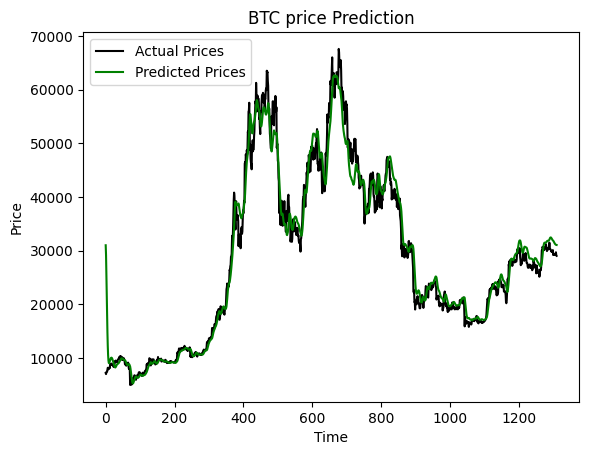

In [ ]:
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title('BTC price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc = 'upper left')
plt.show()

# Predict next day

In [ ]:
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)


In [ ]:
real_data.shape

(1, 59)

In [ ]:
real_data = np.reshape(real_data, (real_data.shape[0],real_data.shape[1], 1))

In [ ]:
prediction = model.predict(real_data)
prediction = scalar.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 1s 1s/step
[[30993.459]]


In [ ]:
# Save the prediction value to Firebase Firestore
db = firestore.client()
doc_ref = db.collection('predictioncrypto').document(crypto_currency)
doc_ref.set({
    'prediction': float(prediction[0][0])
})

update_time {
  seconds: 1691396717
  nanos: 96920000
}